In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from itertools import groupby

import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

import networkx as nx

from minimal.imaging import draw_plan, blit_rooms
from minimal.layout import NodeType, NODE_COLOR, NODE_NAME
from minimal import sample_graphs
from minimal.gen import _load_segmentation_dict
from minimal.lib import gen_segmentation_mask, assemble_plan
from minimal.doors import create_cut_wall_mask

%matplotlib inline

In [3]:
layout, masks = _load_segmentation_dict(torch.load("data/sgm_01.pth"))

In [18]:
# layout = sample_graphs.two()

In [20]:
# %%time

# masks = gen_segmentation_mask(layout)

CPU times: user 1min 24s, sys: 9.32 s, total: 1min 33s
Wall time: 26.7 s


In [4]:
scale = (3, 3)

In [107]:
%%time

rect_graphs, wall_runs, doors = assemble_plan(layout, masks, scale)

CPU times: user 512 ms, sys: 0 ns, total: 512 ms
Wall time: 418 ms


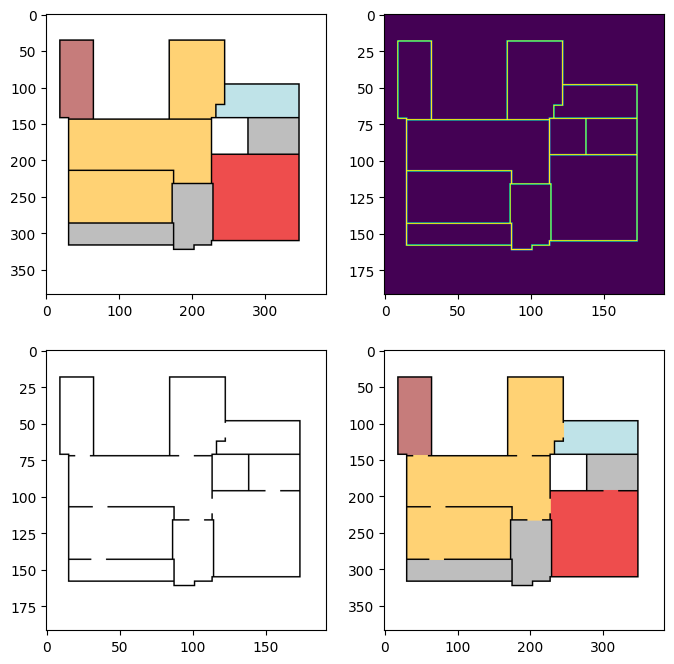

In [108]:
walls = create_cut_wall_mask(sep_mask, doors)

plt.figure(figsize=(8,8))

plt.subplot(221)
plt.imshow(blit_rooms(rect_graphs, sep_mask, out_size=384))

plt.subplot(222)
plt.imshow((sep_mask > 0).byte())

plt.subplot(223)
plt.imshow(1 - walls, cmap="gray")

plt.subplot(224)
plt.imshow(blit_rooms(rect_graphs, walls, out_size=384))

In [109]:
rooms_encoded = []
for i, r in enumerate(rect_graphs):
    room_data = [r.room_type]
    for _, d in r.rects_graph.nodes(data=True):
        room_data.extend(d['xywh'])

    rooms_encoded.append(room_data)

In [110]:
plan_json = json.dumps({
    'shape': tuple(sep_mask.shape),
    'scale': scale,
    "rooms": rooms_encoded,
    "walls": wall_runs,
    "doors": doors
})
print(plan_json)

{"shape": [192, 192], "rooms": [[3, 24, 46, 12, 8], [3, 48, 5, 24, 5], [3, 39, 29, 9, 14, 53, 29, 5, 1], [4, 16, 41, 17, 8, 21, 39, 2, 3], [1, 6, 3, 8, 18], [2, 6, 28, 11, 18, 6, 39, 2, 15], [2, 36, 5, 24, 12], [0, 32, 38, 20, 20], [2, 24, 5, 33, 12, 36, 29, 9, 3]], "walls": [[18, 10, 22, "h"], [18, 85, 37, "h"], [48, 123, 50, "h"], [72, 16, 97, "h"], [96, 114, 59, "h"], [19, 32, 53, "v"], [117, 86, 26, "v"], [159, 101, 2, "v"], [73, 113, 43, "v"], [156, 113, 2, "v"], [63, 116, 8, "v"], [19, 122, 43, "v"], [49, 173, 22, "v"], [72, 173, 24, "v"], [97, 173, 58, "v"], [62, 117, 5, "h"], [71, 10, 5, "h"], [71, 114, 2, "h"], [71, 117, 56, "h"], [107, 16, 71, "h"], [116, 88, 25, "h"], [143, 16, 70, "h"], [155, 115, 58, "h"], [158, 16, 71, "h"], [158, 102, 11, "h"], [161, 88, 13, "h"], [19, 9, 52, "v"], [73, 15, 34, "v"], [108, 15, 35, "v"], [144, 15, 14, "v"], [19, 84, 53, "v"], [108, 87, 8, "v"], [144, 87, 17, "v"], [117, 114, 38, "v"], [72, 138, 24, "v"]], "doors": [[116, 98, 10, "h"], [96

In [106]:
with open("plan.json", "w") as f:
    f.write(plan_json)

In [78]:
len(all_wall_runs(face_walls)

35